# Test di Kolmogorov-Smirnov

Il test serve per determinare quanto un campione è compatibile con una distribuzione teorica.

In [1]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np
import math

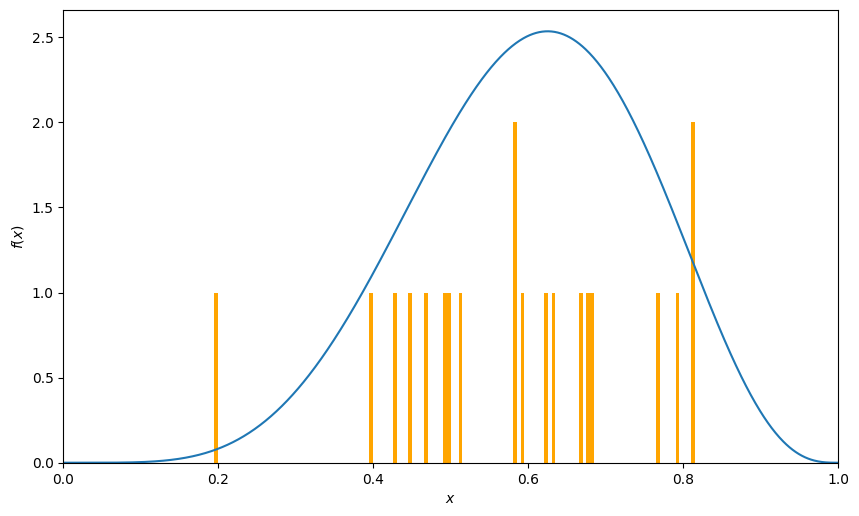

In [16]:
model = beta(6, 4)
sample = model.rvs(20)
xs = np.linspace(0, 1, 1001)
ys = model.pdf(xs)
plt.figure(figsize=(10,6), dpi=100)
plt.plot(xs,ys)
plt.hist(sample, bins=200, range=(0,1), color='orange')
plt.ylim(bottom=0)
plt.xlim(0,1)
plt.xlabel('$x$')
plt.ylabel(r'$f(x)$')
plt.show()

Il test confronta la distribuzione cumulativa della PDF con la distribuzione cumulativa ottenuta sommando funzioni a gradino a partire da ciascun elemento del campione considerato:

$\displaystyle F(x) = \int_{-\infty}^x\!\! f(x)\,\mathrm{d}x$

$\displaystyle F_n(x) = \frac{1}{n}\sum_{i=1}^n \theta\,(x-x_i)$

dove $\theta$ è la funzione gradino:

$\displaystyle \theta\,(x) = \left\{
\begin{array}{ccc}
1 & \mathrm{se} & x\ge 0\\
0 & \mathrm{se} & x <0
\end{array}
\right.
$

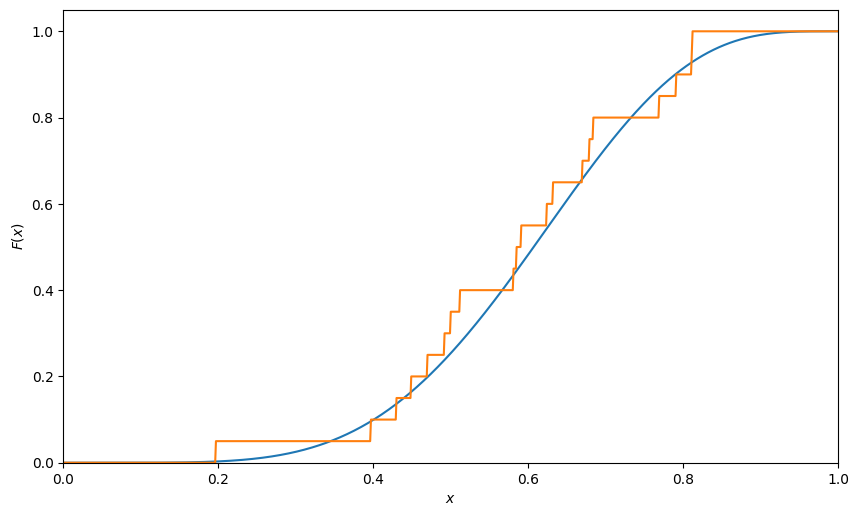

In [17]:
yc = model.cdf(xs)
def samplec(x):
    u, c = np.unique(sample < x, return_counts=True)
    d = dict(zip(u, c))
    return (d[True]/len(sample)) if (True in d.keys()) else 0.0
sc = (np.vectorize(samplec))(xs)
plt.figure(figsize=(10,6), dpi=100)
plt.plot(xs,yc)
plt.plot(xs,sc)
plt.ylim(0)
plt.xlim(0,1)
plt.xlabel('$x$')
plt.ylabel(r'$F(x)$')
plt.show()

Lo stimatore della consistenza tra il campione e la funzione si ottiene a partire dal valore massimo della discrepanza:

$\displaystyle D_n = \sup_x\left|F_n(x) - F(x)\right|$

La distribuzione di probabilità dello stimatore $K = \sqrt{n}D_n$ tende, per $n\rightarrow \infty$, ad una funzione nota e calcolabile, la cui distribuzione cumulativa è:

$\displaystyle F(k) = P(K\le k) = 1-2\sum_{i=1}^\infty (-1)^{i-1}e^{-i^2k^2} = 
\frac{\sqrt{2\pi}}{k}\sum_{i=1}^\infty e^{-(2i-1)^2\pi^2/8k^2}
$

Soprattutto, è implementata in python come [```kstest```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html).

In [18]:
k = np.abs(yc-sc).max()
print("K =", k)
print("x = ", xs[np.abs(yc-sc)==k])

K = 0.12191131169862046
x =  [0.512]


In [19]:
from scipy import stats
D, p = stats.kstest(sample, model.cdf)
print("D={:.4f}, p={:.4f}".format(D, p))

D=0.1224, p=0.8902


Il $p$-value permette di rigettare o meno l'ipotesi $H_0$ che la distribuzione segua la funzione $f$.

## Test a due campioni

Si possono anche confrontare due campioni ed ottenere un $p$-value che corrisponde all'ipotesi che i due siano stati estratti dalla stessa distribuzione.

Viene calcolato il massimo della distanza tra le due funzioni a gradino:

$\displaystyle D_{n,m} = \sup_x\left|F_n(x) - F_m(y)\right|$

Asintoticamente, lo statistic:

$\displaystyle \sqrt{\frac{nm}{n+m}}D_{n,m}$

segue la distribuzione di Kolmogorov riportata sopra.

L'implementazione è in [```ks_2samp```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html)

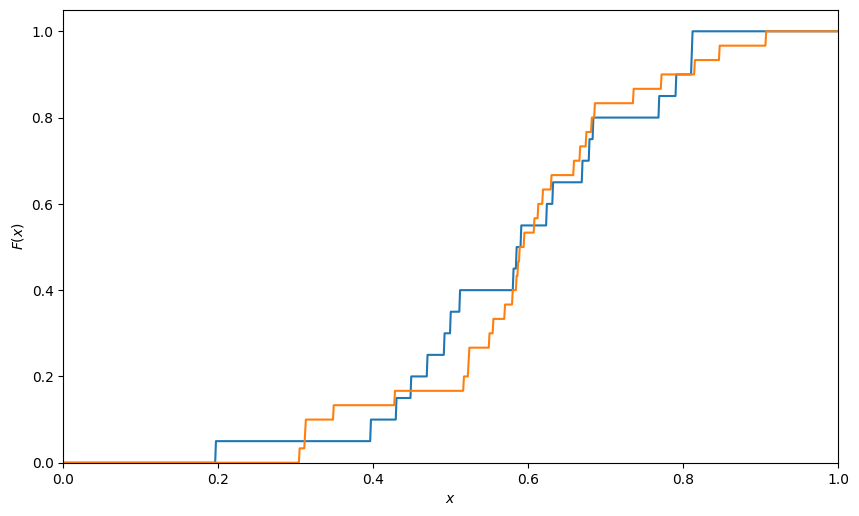

In [20]:
sample1 = model.rvs(30)
yc = model.cdf(xs)
def sample1c(x):
    u, c = np.unique(sample1 < x, return_counts=True)
    d = dict(zip(u, c))
    return (d[True]/len(sample1)) if (True in d.keys()) else 0.0
s1c = (np.vectorize(sample1c))(xs)
plt.figure(figsize=(10,6), dpi=100)
plt.plot(xs,sc)
plt.plot(xs,s1c)
plt.ylim(0)
plt.xlim(0,1)
plt.xlabel('$x$')
plt.ylabel(r'$F(x)$')
plt.show()

In [22]:
D, p = stats.ks_2samp(sample, sample1)
print("D={:.4f}, p={:.4f}".format(D, p))

D=0.2333, p=0.4856


## Test di Kolmogorov-Smirnov parametrico

<span style="color:red">Attenzione: il test di Kolmogorov-Smirnov non è valido se la funzione ha uno o più parametri che sono stati stimati dai dati stessi!</span>

Nel caso in cui volessimo confrontare, ad esempio, la distribuzione di un campione con la curva che otteniamo da un fit del campione stesso, sia che si tratti del fit di un istogramma oppure di un fit *unbinned*, possiamo usare il discriminante di Kolmogorof:

$\displaystyle D = \sup_x\left|F_n(x) - F(x)\right|$

ma $D$ questa volta non seguirà la distribuzione di Kolmogorov!

Se vogliamo usare ancora $D$ per determinare il $p$-value del nostro test, dobbiamo studiarne la distribuzione con un *toy Monte Carlo*. Ossia: generiamo tanti campioni fittizi che seguono la curva teorica; per ciascuno facciamo il fit e determiniamo $D$. La distribuzione di $D$ la otterremo, approssimativamente, in base a quella dei nostri campioni simulati. Possiamo determinare il $p$-value di un valore osservato $\hat{D}$ come la frazione di casi simulati in cui $D>\hat{D}$.